# Classification

## Objectives

*   Fit and evaluate a classification model to predict if a treatment will be successful or not.


## Inputs

* outputs/datasets/collection/FertilityTreatmentData.csv.gz
* Instructions from the notebooks 02 and 04 on which variables to use for data cleaning and feature engineering.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot


---

## Change working directory

Change the working directory from its current folder to its parent folder
* Access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/jupyter_notebooks'

To make the parent of the current directory the new current directory:
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("A new current directory has been set")

A new current directory has been set


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor'

---

## Step 1: Load Data

In [4]:
import numpy as np
import pandas as pd

# Open dataset
df = pd.read_csv("outputs/datasets/collection/FertilityTreatmentData.csv.gz")
        
print(df.shape)
df.head(3)

(169616, 61)


/var/folders/ps/q2jlnsf17tx866fp04k_jkg00000gn/T/ipykernel_17058/3215408494.py:5: DtypeWarning: Columns (4,38,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("outputs/datasets/collection/FertilityTreatmentData.csv.gz")


,Patient age at treatment,Total number of previous IVF cycles,Total number of previous DI cycles,Total number of previous pregnancies - IVF and DI,Total number of previous live births - IVF or DI,Causes of infertility - tubal disease,Causes of infertility - ovulatory disorder,Causes of infertility - male factor,Causes of infertility - patient unexplained,Causes of infertility - endometriosis,...,Heart three weeks gestation,Heart three birth outcome,Heart three birth weight,Heart three sex,Heart three birth congenital abnormalities,Heart three delivery date,Patient ethnicity,Partner ethnicity,Partner Type,Partner age
0,45-50,3,0,0.0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,Black,Other,Male,NaN
1,18-34,0,0,NaN,NaN,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,White,Other,NaN,NaN
2,999,0,0,NaN,NaN,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,Other,Other,NaN,NaN


---

## Step 2: ML Pipeline with all data

#### ML pipeline for Data Cleaning and Feature Engineering

Custom Transformers:

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin


class FilterIVFTreatments(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.query(
            "`Main reason for producing embroys storing eggs` == 'Treatment - IVF'"
        )

class DropErroneousEntries(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(
            X[(X["Live birth occurrence"] == 1) & (X["Embryos transferred"] == 0)].index
        )

class ConvertToNumeric(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            # Replace '>3' with 4
            X[col] = X[col].replace(">3", 4)
            # Convert to numeric
            X[col] = pd.to_numeric(X[col])
        return X


class ConvertToIntegers(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            # Replace '>3' with 4 and convert to int
            X[col] = X[col].replace(">3", 4).astype(float).astype(int)
        return X


class FillSpermSource(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["Sperm source"] = X.apply(self._fill_sperm_source, axis=1)
        return X

    def _fill_sperm_source(self, row):
        if pd.isna(row["Sperm source"]):
            if not pd.isna(row["Sperm donor age at registration"]):
                return "Donor"
            else:
                return "Partner"
        return row["Sperm source"]


# Convert float values to integers and handle NaN values
class ConvertToIntAndReplace999(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Fill NaN with -1 and convert to int
        X["Date of embryo transfer"] = (
            X["Date of embryo transfer"].fillna(-1).astype(int)
        )
        # Replace 999 with 0
        X["Date of embryo transfer"] = X["Date of embryo transfer"].replace(999, 0)
        return X


# Replace missing values based on the "Embryos transferred" column
class ReplaceMissingValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["Date of embryo transfer"] = X.apply(self._replace_missing, axis=1)
        return X

    def _replace_missing(self, row):
        value = row["Date of embryo transfer"]
        if value == -1 and row["Embryos transferred"] == 0:
            return "NT"
        elif value == -1:
            return "Missing"
        return value


# Append strings based on the "Fresh cycle" and "Frozen cycle" values
class AppendCycleType(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["Date of embryo transfer"] = X.apply(self._append_cycle_type, axis=1)
        return X

    def _append_cycle_type(self, row):
        value = row["Date of embryo transfer"]
        if value not in ["NT", "Missing"]:
            if row["Fresh cycle"] == 1:
                value = f"{value} - fresh"
            elif row["Frozen cycle"] == 1:
                value = f"{value} - frozen"
            else:
                value = f"{value} - Mixed fresh/frozen"
        return value


class MicroInjectedEmbryos(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Embryos transferred from eggs micro-injected imputation
        missing_micro_injected = X[
            "Embryos transferred from eggs micro-injected"
        ].isna()
        ICSI = X["Specific treatment type"].str.contains("ICSI")
        # Only replace missing values
        X.loc[
            missing_micro_injected & ICSI,
            "Embryos transferred from eggs micro-injected",
        ] = X.loc[missing_micro_injected & ICSI, "Embryos transferred"]
        X.loc[
            missing_micro_injected & ~ICSI,
            "Embryos transferred from eggs micro-injected",
        ] = 0

        return X


class DonorAgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Mapping from donor age ranges to patient/partner age ranges
        self.egg_age_map = {
            "Between 21 and 25": "18-34",
            "Between 26 and 30": "18-34",
            "Between 31 and 35": "18-34",
            ">35": "38-39",
            "<= 20": "18-34",
        }
        self.sperm_age_map = {
            "Between 21 and 25": "18-34",
            "Between 26 and 30": "18-34",
            "Between 31 and 35": "18-34",
            "Between 36 and 40": "38-39",
            "Between 41 and 45": "43-44",
            ">45": "45-50",
            "<= 20": "18-34",
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Egg donor age imputation
        X["Egg donor age at registration"] = X["Egg donor age at registration"].map(
            self.egg_age_map
        )
        missing_egg_age = (X["Egg donor age at registration"].isna()) & (
            X["Egg source"] == "Patient"
        )
        X.loc[missing_egg_age, "Egg donor age at registration"] = X.loc[
            missing_egg_age, "Patient age at treatment"
        ]
        X.rename(
            columns={"Egg donor age at registration": "Patient/Egg provider age"},
            inplace=True,
        )

        # Sperm donor age imputation
        X["Sperm donor age at registration"] = X["Sperm donor age at registration"].map(
            self.sperm_age_map
        )
        missing_sperm_age = (X["Sperm donor age at registration"].isna()) & (
            X["Sperm source"] == "Partner"
        )
        X.loc[missing_sperm_age, "Sperm donor age at registration"] = X.loc[
            missing_sperm_age, "Partner age"
        ]
        X.rename(
            columns={"Sperm donor age at registration": "Partner/Sperm provider age"},
            inplace=True,
        )

        # Ensure no duplicate columns
        if X.columns.duplicated().any():
            raise ValueError("Duplicate column names found after transformation")

        return X


class FloatToIntTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.float_vars = None

    def fit(self, X, y=None):
        # Identify float columns
        self.float_vars = X.select_dtypes(include="float").columns.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        for var in self.float_vars:
            X[var] = X[var].astype(int)
        return X


class EFlaggingTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        X["Embryos transferred"] = X.apply(self.append_e, axis=1)
        return X

    def append_e(self, row):
        if (
            row["Embryos transferred"] == 1
            and row["Elective single embryo transfer"] == 1
        ):
            return "1e"
        else:
            return row["Embryos transferred"]


class TypeOfCycleAppender(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_update):
        self.columns_to_update = columns_to_update

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Ensure columns have the correct data type to avoid issues
        for column in self.columns_to_update:
            X[column] = X[column].astype(str)

        # Apply transformation for frozen cycle
        for column in self.columns_to_update:
            X.loc[(X["Frozen cycle"] == 1) & (X[column] == "0"), column] = (
                "0 - frozen cycle"
            )

        # Apply transformation for fresh cycle
        X["Total embryos thawed"] = X["Total embryos thawed"].astype(str)
        X.loc[
            (X["Fresh cycle"] == 1) & (X["Total embryos thawed"] == "0"),
            "Total embryos thawed",
        ] = "0 - fresh cycle"

        return X

#### Pipeline

In [6]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures, SmartCorrelatedSelection
from feature_engine.imputation import ArbitraryNumberImputer, DropMissingData
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder

# Columns to drop
columns_to_drop = [
    "Main reason for producing embroys storing eggs",
    "Type of treatment - IVF or DI",
    "Donated embryo",
    "Eggs thawed (0/1)",
    "Year of treatment",
    "Number of live births",
    "Embryos stored for use by patient",
    "Fresh eggs stored (0/1)",
    "Heart three birth congenital abnormalities",
    "Heart two birth congenital abnormalities",
    "Heart three delivery date",
    "Heart three sex",
    "Heart three birth weight",
    "Heart three weeks gestation",
    "Heart three birth outcome",
    "Heart one birth congenital abnormalities",
    "Heart two birth weight",
    "Heart two delivery date",
    "Heart two sex",
    "Heart two weeks gestation",
    "Heart two birth outcome",
    "Heart one birth weight",
    "Heart one weeks gestation",
    "Heart one delivery date",
    "Heart one sex",
    "Heart one birth outcome",
    "Number of foetal sacs with fetal pulsation",
    "Early outcome",
    "Partner Type",
]

# Columns to be updated with the type of cycle
columns_to_update = [
    "Fresh eggs collected",
    "Total eggs mixed",
    "Total embryos created",
]

def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline(
        [
            # Data Cleaning Steps
            ("filter_ivf", FilterIVFTreatments()),
            ("drop_erroneous", DropErroneousEntries()),
            ("drop_columns", DropFeatures(features_to_drop=columns_to_drop)),
            (
                "convert_to_numeric",
                ConvertToNumeric(
                    columns=[
                        "Total number of previous pregnancies - IVF and DI",
                        "Total number of previous live births - IVF or DI",
                    ]
                ),
            ),
            (
                "zeros_imputer",
                ArbitraryNumberImputer(
                    arbitrary_number=0,
                    variables=[
                        "Total number of previous pregnancies - IVF and DI",
                        "Total number of previous live births - IVF or DI",
                    ],
                ),
            ),
            (
                "convert_to_int",
                ConvertToIntegers(
                    columns=[
                        "Total number of previous pregnancies - IVF and DI",
                        "Total number of previous live births - IVF or DI",
                    ]
                ),
            ),
            ("fill_sperm_source", FillSpermSource()),  
            ("dot_to_int_999", ConvertToIntAndReplace999()),  
            ("replace_missing_values", ReplaceMissingValues()),  
            ("append_cycle_type", AppendCycleType()),  
            ("micro_injected", MicroInjectedEmbryos()),  
            ("donor_age", DonorAgeImputer()),  
            ("float_to_int", FloatToIntTransformer()),  
            ("e_flagging", EFlaggingTransformer()),  
            ("type_of_cycle", TypeOfCycleAppender(columns_to_update=columns_to_update)),
            ("drop_missing_data", DropMissingData()),

            # Feature Engineering Steps
            (
                "ordinal_encoding",
                OrdinalEncoder(
                    encoding_method='arbitrary',
                    variables=[
                        "Patient age at treatment",
                        "Partner/Sperm provider age",
                        "Patient/Egg provider age",
                        "Total number of previous IVF cycles",
                        "Total number of previous DI cycles",
                        "Fresh eggs collected",
                        "Total eggs mixed",
                        "Total embryos created",
                        "Embryos transferred",
                        "Total embryos thawed",
                        "Date of embryo transfer",
                        "Partner age"
                    ]
                ),
            ),
            (
                "one_hot_encoding",
                OneHotEncoder(
                    variables=[
                        "Specific treatment type",
                        "Egg source",
                        "Sperm source",
                        "Patient ethnicity",
                        "Partner ethnicity",
                    ]
                ),
            ),
            ("smart_correlation", SmartCorrelatedSelection()),
        ]
    )

    return pipeline_base

PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('filter_ivf', FilterIVFTreatments()),
                ('drop_erroneous', DropErroneousEntries()),
                ('drop_columns',
                 DropFeatures(features_to_drop=['Main reason for producing '
                                                'embroys storing eggs',
                                                'Type of treatment - IVF or DI',
                                                'Donated embryo',
                                                'Eggs thawed (0/1)',
                                                'Year of treatment',
                                                'Number of live births',
                                                'Embryos stored for use by '
                                                'patient',
                                                'Fresh eggs stored (0/1)',
                                                'Heart th...
                                           'Total number of previous DI cycles',
                                           'Fresh eggs collected',
                                           'Total eggs mixed',
                                           'Total embryos created',
                                           'Embryos transferred',
                                           'Total embryos thawed',
                                           'Date of embryo transfer',
                                           'Partner age'])),
                ('one_hot_encoding',
                 OneHotEncoder(variables=['Specific treatment type',
                                          'Egg source', 'Sperm source',
                                          'Patient ethnicity',
                                          'Partner ethnicity'])),
                ('smart_correlation', SmartCorrelatedSelection())])

### ML Pipeline for Modelling and Hyperparameter Optimisation

In [7]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
)
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("feat_selection", SelectFromModel(model)),
            ("model", model),
        ]
    )

    return pipeline_base

Custom Class for Hyperparameter Optimisation using GridSearchCV

In [8]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs=-1, verbose=1, scoring=None, refit="f1"):
        for key in self.keys:
            print(
                f"\nRunning GridSearchCV for {key} with {len(self.params[key])} parameter combinations.\n"
            )

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(
                model,
                params,
                cv=cv,
                n_jobs=n_jobs,
                verbose=verbose,
                scoring=scoring,
                refit=refit,
            )
            gs.fit(X, y)
            self.grid_searches[key] = gs
            
    def score_summary(self, sort_by="f1", scoring=None):
        if scoring is None:
            raise ValueError("Scoring dictionary must be provided")
        
        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_["params"]
            mean_scores = {
                metric: self.grid_searches[k].cv_results_[f"mean_test_{metric}"]
                for metric in scoring.keys()
            }
            
            for i in range(len(params)):
                row_data = {"estimator": k, **params[i]}
                row_data.update({f"mean_{metric}": mean_scores[metric][i] for metric in mean_scores})
                rows.append(pd.Series(row_data))
        
        df = pd.DataFrame(rows).sort_values([f"mean_{sort_by}"], ascending=False)
        return df, self.grid_searches


### Split Train and Test Set

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    # Do not drop the target column here because it is needed for the pipeline
    df,
    df["Live birth occurrence"],
    test_size=0.2,
    random_state=0,
)


## Handle Target Imbalance

Apply the data cleaning and feature engineering pipeline

In [10]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)

Realign y_train indices with the transformed X_train to keep only the rows present on the dataset after the cleaning step

In [11]:
y_train = y_train.loc[X_train.index]

Apply the pipeline to the test set and realign indices on y_test

In [12]:
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
y_test = y_test.loc[X_test.index]


Drop the target column from the processed X_train and X_test

In [13]:
X_train = X_train.drop(["Live birth occurrence"], axis=1)
X_test = X_test.drop(["Live birth occurrence"], axis=1)

In [14]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(104940, 38) (104940,) (26228, 38) (26228,)


Check Train Set Target distribution

0    74793
1    30147
Name: Live birth occurrence, dtype: int64


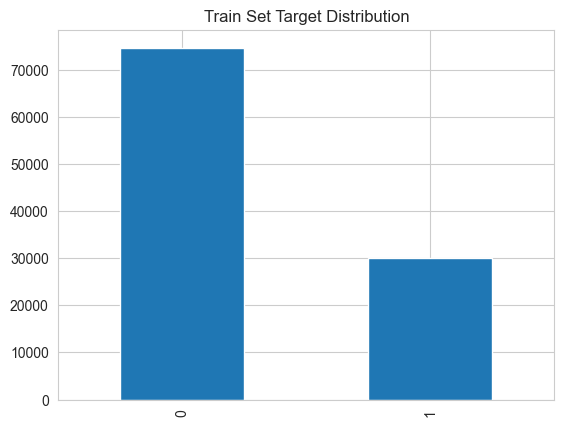

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

print(y_train.value_counts())

sns.set_style("whitegrid")
y_train.value_counts().plot(kind="bar", title="Train Set Target Distribution")
plt.show()

### Use SMOTE (Synthetic Minority Oversampling TEchnique) to balance Train Set target

In [16]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(149586, 38) (149586,) (26228, 38) (26228,)


Check Train Set Target distribution after resampling

1    74793
0    74793
Name: Live birth occurrence, dtype: int64


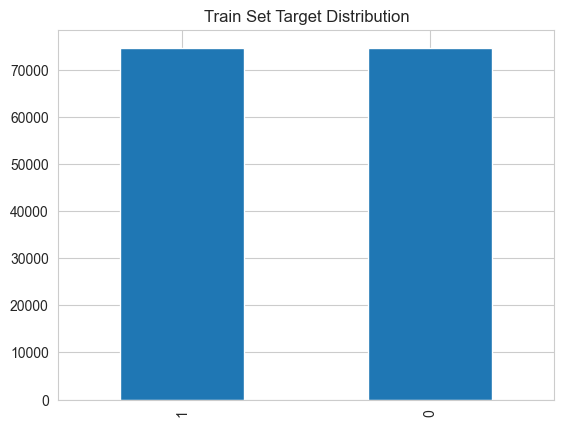

In [17]:
import matplotlib.pyplot as plt

print(y_train.value_counts())

y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

## Grid Search CV - Sklearn

### Use standard hyperparameters to find most suitable algorithm 

Set Up the Models and Parameters

In [18]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "XGBLogitBoost": XGBClassifier(objective="binary:logistic", random_state=0)
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
    "XGBLogitBoost": {}
}

Define the custom scoring metrics

In [19]:
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def npv_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fn)

# Dictionary of all the metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, pos_label=1),
    'specificity': make_scorer(specificity_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'npv': make_scorer(npv_score),
    'mcc': make_scorer(matthews_corrcoef),
    'f1': make_scorer(f1_score, pos_label=1)
}

Quick GridSearch CV - Binary Classifier

In [20]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)

search.fit(X_train, y_train, cv=5, n_jobs=-1, scoring=scoring, refit='f1')


Running GridSearchCV for LogisticRegression with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/patriciahalley/Documents/Code_institute/git/ivf-success-pred


Running GridSearchCV for XGBLogitBoost with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [21]:
# Get the results and sort by the F1 score
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='f1', scoring=scoring)
grid_search_summary


,estimator,mean_accuracy,mean_recall,mean_specificity,mean_precision,mean_npv,mean_mcc,mean_f1
3,RandomForestClassifier,0.685305,0.798111,0.572500,0.650158,0.745503,0.382882,0.715872
5,ExtraTreesClassifier,0.681147,0.783083,0.579212,0.649519,0.731749,0.371636,0.709629
2,DecisionTreeClassifier,0.671006,0.785730,0.556282,0.638319,0.725489,0.352718,0.704071
4,GradientBoostingClassifier,0.653230,0.813553,0.492908,0.616014,0.726369,0.323904,0.701030
1,XGBClassifier,0.656866,0.797964,0.515770,0.621767,0.724709,0.329607,0.698212
7,XGBLogitBoost,0.656866,0.797964,0.515770,0.621767,0.724709,0.329607,0.698212
6,AdaBoostClassifier,0.658798,0.784526,0.533071,0.626393,0.715465,0.329471,0.696226
0,LogisticRegression,0.559230,0.477215,0.641251,0.564436,0.563326,0.122700,0.493219


Get best model name programmatically

In [22]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

Parameters for best model

In [23]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{}

Define the best clf pipeline

In [24]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model', RandomForestClassifier(random_state=0))])

In [25]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print("---  Confusion Matrix  ---")
    print(
        pd.DataFrame(
            confusion_matrix(y_true=prediction, y_pred=y),
            columns=[["Actual " + sub for sub in label_map]],
            index=[["Prediction " + sub for sub in label_map]],
        )
    )
    print("\n")

    print("---  Classification Report  ---")
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

In [26]:
print("***Performance of the best model on the Oversampling imbalance handle strategy:***\n")

clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Success', 'Success'] 
                )

***Performance of the best model on the Oversampling imbalance handle strategy:***

#### Train Set #### 

---  Confusion Matrix  ---
                      Actual No Success Actual Success
Prediction No Success             48121           9546
Prediction Success                26672          65247


---  Classification Report  ---
              precision    recall  f1-score   support

  No Success       0.83      0.64      0.73     74793
     Success       0.71      0.87      0.78     74793

    accuracy                           0.76    149586
   macro avg       0.77      0.76      0.75    149586
weighted avg       0.77      0.76      0.75    149586
 

#### Test Set ####

---  Confusion Matrix  ---
                      Actual No Success Actual Success
Prediction No Success             10620           2612
Prediction Success                 8136           4860


---  Classification Report  ---
              precision    recall  f1-score   support

  No Success       0.80      0.57     

### Perform extensive and comprehensive search on the most suitable algorithm to find the best hyperparameter configuration using GridSearchCV

Define model and parameters, for Extensive Search

In [27]:
models_search = {
    'RandomForestClassifier': RandomForestClassifier()
}

params_search = {
    'RandomForestClassifier': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [5, 10, 15],
        'model__bootstrap': [True],
        'model__min_samples_leaf': [5, 10, 20],
        'model__max_features': ['sqrt', 'log2', 0.75],
        'model__class_weight': [{0: 1, 1: 2}, {0: 1, 1: 5}, 'balanced'],  # Adding class_weight
    }
}


# models_search = {
#     "RandomForestClassifier": RandomForestClassifier(random_state=0),
# }


# params_search = {
#     "RandomForestClassifier": {
#         "model__n_estimators": [300, 700, 1000],
#         "model__max_depth": [None, 20, 25],
#         "model__min_samples_split": [2, 10, 20],
#         "model__min_samples_leaf": [2, 5, 10],
#         "model__max_features": ["sqrt", "log2", 0.75],
#         "model__bootstrap": [True, False],
#         "model__class_weight": ['balanced', 'balanced_subsample', None],
#         "model__max_samples": [0.5, 0.7, None]  # Only relevant if bootstrap=True
#     },
# }

Extensive GridSearch CV - Binary Classifier

In [28]:
print(y_train.value_counts())

search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, cv=5, n_jobs=-1, scoring=scoring, refit='f1')

1    74793
0    74793
Name: Live birth occurrence, dtype: int64

Running GridSearchCV for RandomForestClassifier with 6 parameter combinations.

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Check results

In [29]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='f1', scoring=scoring)
grid_search_summary 

,estimator,model__bootstrap,model__class_weight,model__max_depth,model__max_features,model__min_samples_leaf,model__n_estimators,mean_accuracy,mean_recall,mean_specificity,mean_precision,mean_npv,mean_mcc,mean_f1
72,RandomForestClassifier,True,"{0: 1, 1: 2}",15,0.75,5,100,0.653230,0.942937,0.363523,0.596865,0.872524,0.378963,0.730840
74,RandomForestClassifier,True,"{0: 1, 1: 2}",15,0.75,5,300,0.652849,0.943485,0.362213,0.596524,0.873459,0.378709,0.730740
73,RandomForestClassifier,True,"{0: 1, 1: 2}",15,0.75,5,200,0.652755,0.942990,0.362521,0.596508,0.872465,0.378195,0.730582
76,RandomForestClassifier,True,"{0: 1, 1: 2}",15,0.75,10,200,0.649011,0.944260,0.353763,0.593592,0.871009,0.371807,0.728797
75,RandomForestClassifier,True,"{0: 1, 1: 2}",15,0.75,10,100,0.648945,0.944314,0.353576,0.593533,0.871056,0.371721,0.728770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,RandomForestClassifier,True,balanced,5,0.75,5,200,0.649887,0.827925,0.471849,0.610642,0.732514,0.320725,0.702847
182,RandomForestClassifier,True,balanced,5,0.75,5,300,0.649600,0.828567,0.470632,0.610276,0.732737,0.320350,0.702837
187,RandomForestClassifier,True,balanced,5,0.75,20,200,0.649800,0.828032,0.471568,0.610549,0.732529,0.320594,0.702821
188,RandomForestClassifier,True,balanced,5,0.75,20,300,0.649747,0.828005,0.471488,0.610504,0.732450,0.320480,0.702784


Get best model name programmatically

In [30]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

Parameters for best model

In [31]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__bootstrap': True,
 'model__class_weight': {0: 1, 1: 2},
 'model__max_depth': 15,
 'model__max_features': 0.75,
 'model__min_samples_leaf': 5,
 'model__n_estimators': 100}

Define the best clf pipeline

In [32]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier())),
                ('model',
                 RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=15,
                                        max_features=0.75,
                                        min_samples_leaf=5))])

## Assess feature importance

In [33]:
X_train.head(3)

,Patient age at treatment,Total number of previous IVF cycles,Total number of previous DI cycles,Total number of previous pregnancies - IVF and DI,Causes of infertility - tubal disease,Causes of infertility - ovulatory disorder,Causes of infertility - male factor,Causes of infertility - patient unexplained,Causes of infertility - endometriosis,Patient/Egg provider age,...,Patient ethnicity_White,Patient ethnicity_Mixed,Patient ethnicity_Asian,Patient ethnicity_Black,Patient ethnicity_Other,Partner ethnicity_White,Partner ethnicity_Other,Partner ethnicity_Any other ethnicity,Partner ethnicity_Black,Partner ethnicity_Mixed
0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,1,1,0,0,0,0,0,1,0,1,...,1,0,0,0,0,1,0,0,0,0
2,1,2,0,0,1,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0


Assess feature importance on the current model with `.features_importances_`

* These are the 11 most important features in descending order. The model was trained on them: 
['Embryos transferred', 'Date of embryo transfer', 'Patient/Egg provider age', 'Partner age', 'Total number of previous IVF cycles', 'Patient age at treatment', 'Fresh eggs collected', 'Total embryos created', 'Causes of infertility - male factor', 'Total eggs mixed', 'Total number of previous pregnancies - IVF and DI']


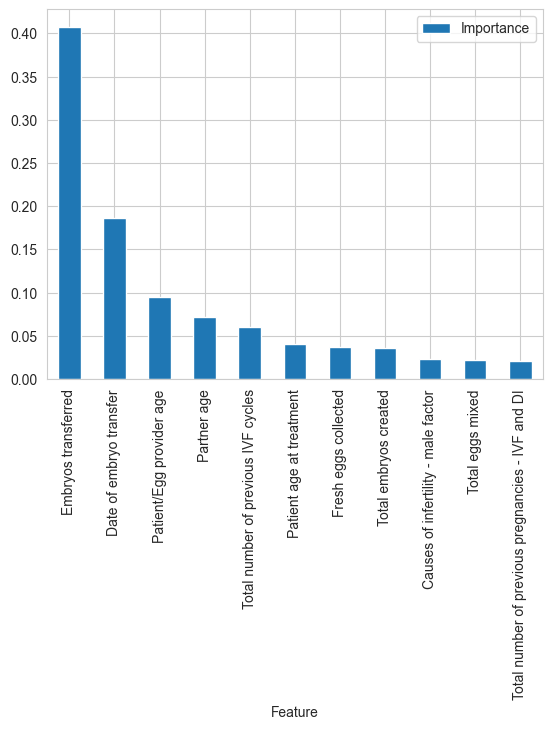

In [34]:
# create DataFrame to display feature importance
df_feature_importance = pd.DataFrame(
    data={
        "Feature": X_train.columns[pipeline_clf["feat_selection"].get_support()],
        "Importance": pipeline_clf["model"].feature_importances_,
    }
).sort_values(by="Importance", ascending=False)

# re-assign best_features order
best_features = df_feature_importance["Feature"].to_list()

# Most important features statement and plot
print(
    f"* These are the {len(best_features)} most important features in descending order. "
    f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}"
)

df_feature_importance.plot(kind="bar", x="Feature", y="Importance")
plt.show()

## Evaluate Pipeline on Train and Test Sets

In [35]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print("---  Confusion Matrix  ---")
    print(
        pd.DataFrame(
            confusion_matrix(y_true=prediction, y_pred=y),
            columns=[["Actual " + sub for sub in label_map]],
            index=[["Prediction " + sub for sub in label_map]],
        )
    )
    print("\n")

    print("---  Classification Report  ---")
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

Evaluation:

In [36]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Success', 'Success'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                      Actual No Success Actual Success
Prediction No Success             28622           2406
Prediction Success                46171          72387


---  Classification Report  ---
              precision    recall  f1-score   support

  No Success       0.92      0.38      0.54     74793
     Success       0.61      0.97      0.75     74793

    accuracy                           0.68    149586
   macro avg       0.77      0.68      0.64    149586
weighted avg       0.77      0.68      0.64    149586
 

#### Test Set ####

---  Confusion Matrix  ---
                      Actual No Success Actual Success
Prediction No Success              6670            757
Prediction Success                12086           6715


---  Classification Report  ---
              precision    recall  f1-score   support

  No Success       0.90      0.36      0.51     18756
     Success       0.36      0.90      0.51      7472

    accuracy 

## Apply Class_weight

In [37]:
# class_weights = {0: 1, 1: 2}  # This assigns twice as much importance to class 1 ('Success') compared to class 0 ('No Success')
# model = RandomForestClassifier(class_weight=class_weights)

---